# Решение задачи

h_x = 5.05050505050505 meters
CPU times: user 933 ms, sys: 1.8 ms, total: 935 ms
Wall time: 935 ms


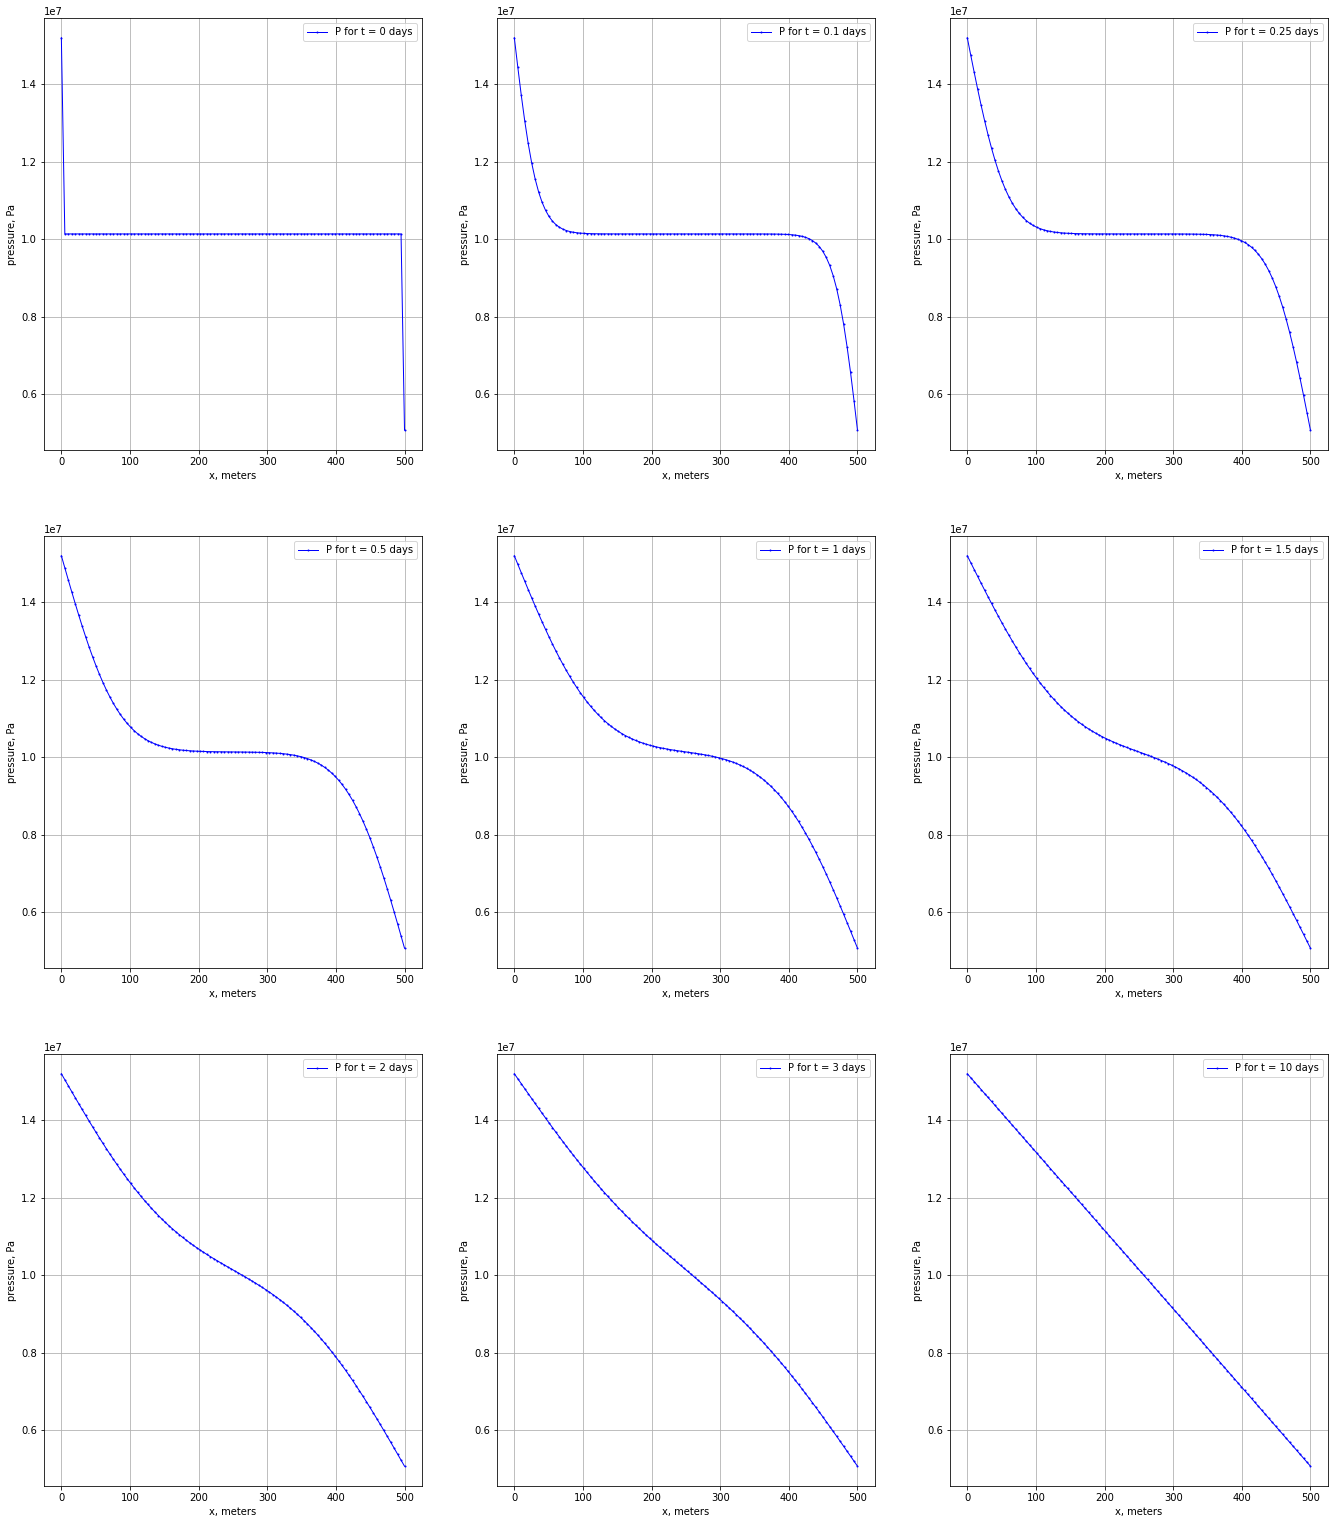

In [0]:
%%time
import time

# решение задачи о плоскопараллельной однофазной фильтрации вязкоупругой жидкости
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 23, 27
from matplotlib import animation, rc
from IPython.display import HTML

# константы
# общие
atm = 101325 # Pa
# расчетная область
L = 500 # m
NX = 100
# начальное условие
p_0 = 100*atm # Pa
# граничные условия
p_inj = 150*atm # Pa
p_prod = 50*atm # Pa
# параметры пласта и жидкости
k = 1e-14 # m^2
mu = 1e-3 # Pa*s
phi = 0.2
c_f = 1e-4/atm # Pa^(-1)
d_0 = 1000 # kg/(m^3) (density - плотность)
p_ref = 120*atm # Pa (референсное значение давления)
# параметры расчета
tau = 2160 # s
t_end = 3600*24*10 # s
dt_out_results = 2*tau # s (0.05 days)

# создание сетки
x = np.linspace(0, L, 100)
h = x[1] 
print('h_x =', h, 'meters')

# функция, рассчитывающая плотность по заданному давлению в узле
def get_density(p):
  return d_0*(1 + c_f*(p - p_ref))

# функция, рассчитывающая плотность по заданному давлению на границе сеточного
# блока со взвешиванием «против потока»
def get_boundary_density(string_parameter, p_central, p_side):
  if (string_parameter == '+'):
    if (p_central >= p_side):
      d = get_density(p_central)
    else:
      d = get_density(p_side)
  else:
    if (p_side >= p_central):
      d = get_density(p_side)
    else:
      d = get_density(p_central)
  return d

# функция, реализующая алгоритм прогонки
def progonka(a, b, c, d, pressure):
  # массивы прогоночных коэффициентов
  p = np.zeros(NX)
  q = np.zeros(NX)

  # прямой ход
  # первое уравнение
  p[1] = -c[0]/b[0]
  q[1] = d[0]/b[0]
  # второе - (NX-1)-ое уравнение
  for i in range(2, NX):
    p[i] = -c[i-1]/(a[i-1]*p[i-1] + b[i-1])
    q[i] = (d[i-1] - a[i-1]*q[i-1])/(a[i-1]*p[i-1] + b[i-1])
  # последнее уравнение
  pressure[NX-1] = (d[NX-1] - a[NX-1]*q[NX-1])/(a[NX-1]*p[NX-1] + b[NX-1])

  # обратный ход
  for i in range(NX-2, -1, -1):
    pressure[i] = pressure[i+1]*p[i+1] + q[i+1]

  return pressure

# функции, рассчитывающие коэффициенты матрицы СЛАУ и правую часть
def get_a(p):
  a = np.zeros(NX)
  for i in range(1, NX-1):
    d = get_boundary_density('-', p[i], p[i-1])
    a[i] = k*d/(mu*(h**2))
  return a

def get_c(p):
  c = np.zeros(NX)
  for i in range(1, NX-1):
    d = get_boundary_density('+', p[i], p[i+1])
    c[i] = k*d/(mu*(h**2))
  return c

def get_b(a, c):
  b = np.ones(NX)
  for i in range(1, NX-1):
    b[i] = -a[i] - c[i] - phi*c_f*d_0/tau
  return b

def get_d(p, p_inj, p_prod):
  d = np.zeros(NX)
  d[0] = p_inj
  for i in range(1, NX-1):
    d[i] = -phi*c_f*d_0*p[i]/tau
  d[NX-1] = p_prod
  return d

# задаем начальный профиль давления p для t = 0
p = np.full(NX, p_0)
p[0] = p_inj
p[NX-1] = p_prod

# массивы для записи результатов
results = np.array([])
results_time = np.array([])

# цикл по времени
t = 0
time_next_output = 0
while(t <= t_end):
  # запись результатов при необходимости
  if (t >= time_next_output):
    results_time = np.append(results_time, t)
    results = np.append(results, p)
    time_next_output += dt_out_results
  # расчет коэффициентов на текущем слое по времени
  a = get_a(p)
  c = get_c(p)
  b = get_b(a, c)
  d = get_d(p, p_inj, p_prod)
  # инкрементирование времени; переход на следующий слой n+1
  t += tau
  # находим давление на этом (n+1)-ом слое
  p = progonka(a, b, c, d, p)

# вывод результатов
reference_times = [0, 0.1, 0.25, 0.5, 1, 1.5, 2, 3, 10] # days
times_index = np.array(reference_times)/(dt_out_results/(24*3600))
#times_index = [0, 2, 5, 10, 20, 30, 40, 60, 200]
for i in range(1, 10):
  plt.subplot(3, 3, i)
  index = int(times_index[i-1])
  time = results_time[index]
  pressure = results[index*NX : (index+1)*NX]
  plt.plot(x, pressure, color='blue', marker='o', linewidth=1, markersize=1,
           label='P for t = ' + str(reference_times[i-1]) + ' days')
  plt.legend()
  plt.grid()
  plt.xlabel('x, meters')
  plt.ylabel('pressure, Pa')
  #plt.title('Получаемые распределения давления в различные моменты времени')

# Дополнительный вывод тех же результатов, но давление теперь имеет размерность атм

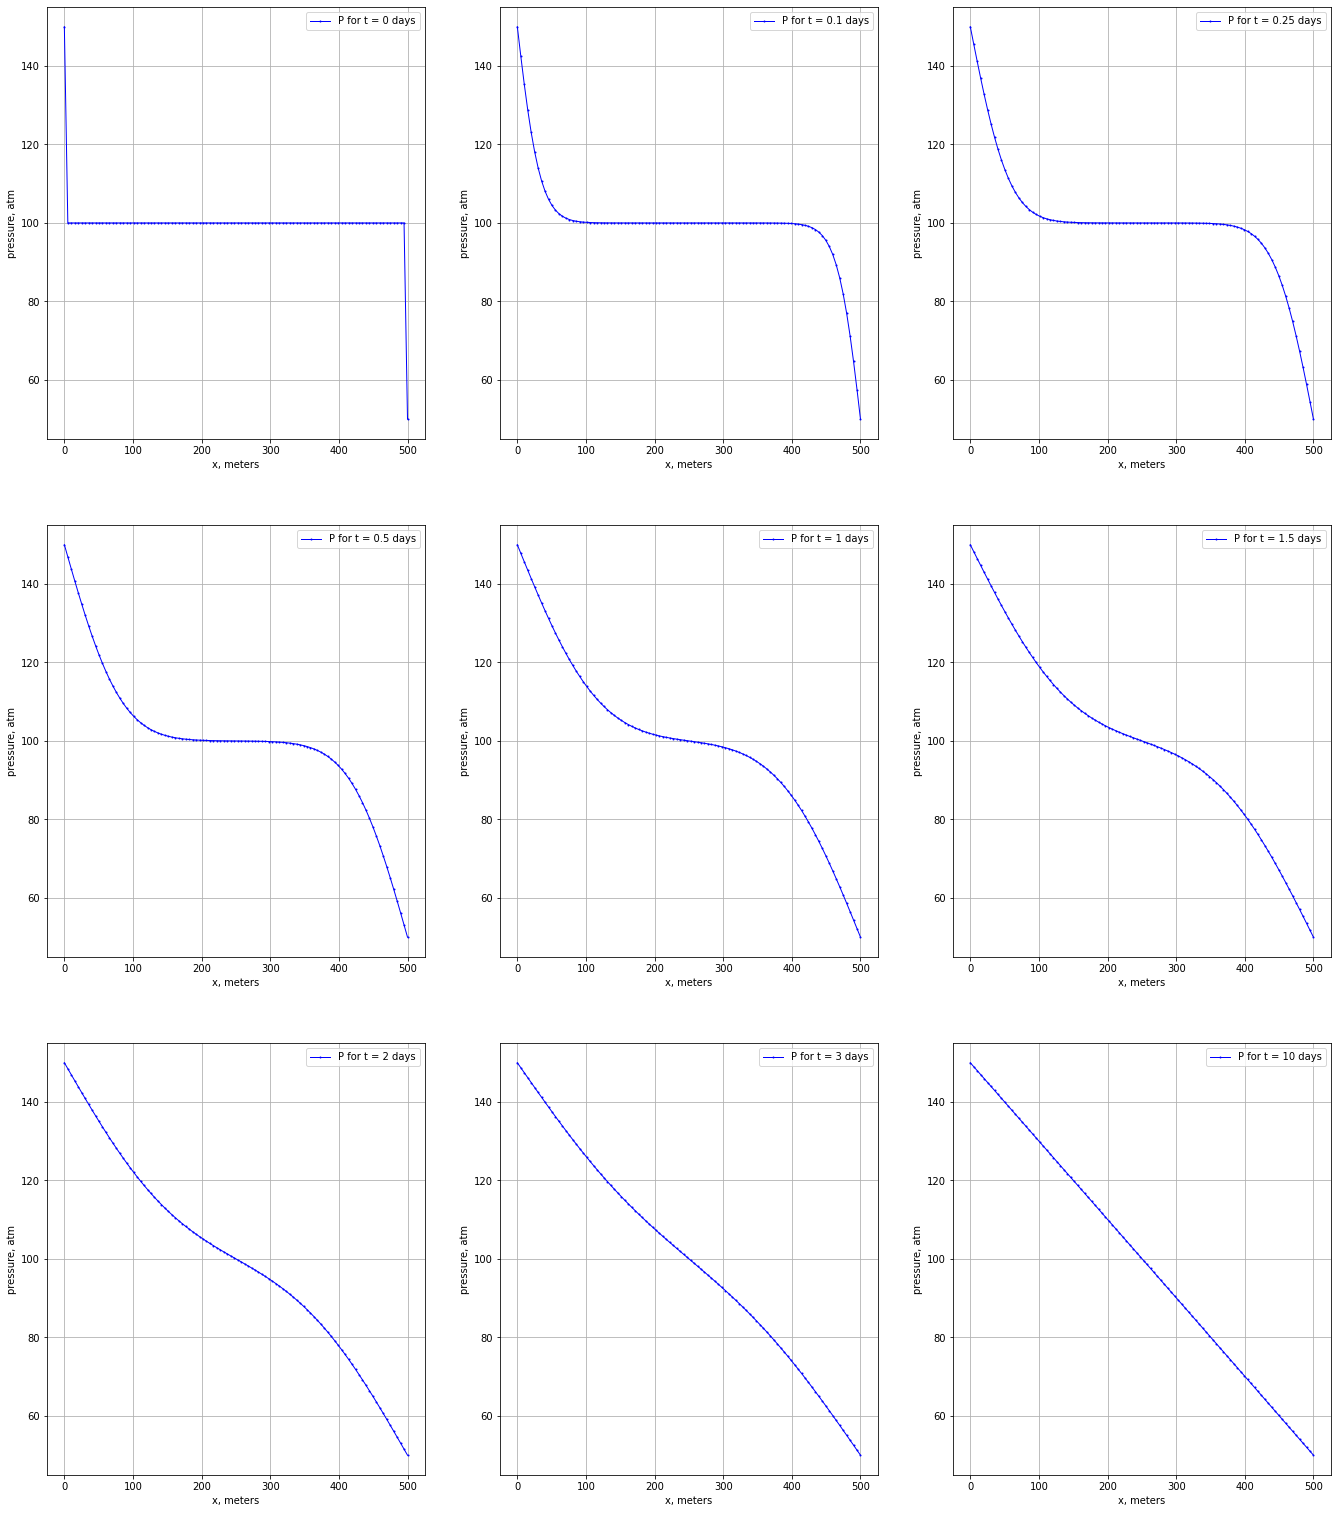

In [0]:
# такой же вывод результатов, но давление теперь в атмосферах
reference_times = [0, 0.1, 0.25, 0.5, 1, 1.5, 2, 3, 10] # days
times_index = np.array(reference_times)/(dt_out_results/(24*3600))
for i in range(1, 10):
  plt.subplot(3, 3, i)
  index = int(times_index[i-1])
  time = results_time[index]
  pressure = (results[index*NX : (index+1)*NX])/atm
  plt.plot(x, pressure, color='blue', marker='o', linewidth=1, markersize=1,
           label='P for t = ' + str(reference_times[i-1]) + ' days')
  plt.legend()
  plt.grid()
  plt.xlabel('x, meters')
  plt.ylabel('pressure, atm')

# Анимация

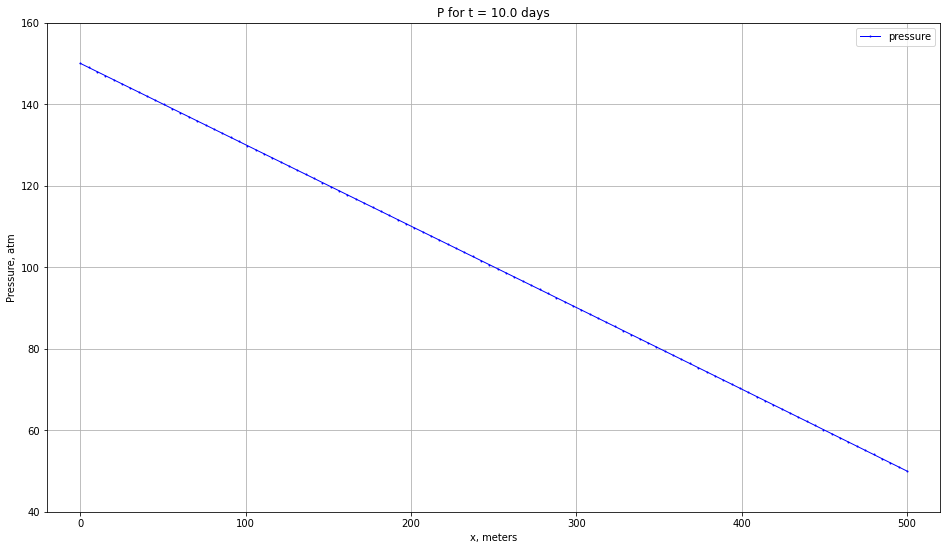

In [0]:
# скрипт, реализующий анимацию
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
ax.set_ylim([40, 160])
ax.set_xlim([-20, 520])
ax.set_xlabel('x, meters')
ax.set_ylabel('Pressure, atm')
ax.grid()

line, = ax.plot([], [], color='blue', marker='o', linewidth=1, markersize=1, label='pressure')
ax.legend()

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    time = results_time/(24*3600)
    actual_time = str(time[i])
    ax.set_title('P for t = ' + actual_time + ' days')
    pressure = (results[i*NX : (i+1)*NX])/atm
    line.set_data(x, pressure)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(results_time), interval=50, blit=True)
HTML(anim.to_html5_video())

# Видео отдельно (для удобства)

In [0]:
HTML(anim.to_html5_video())